Stock Prediction with Recurrent Neural Network

Deep learning is involved a lot in the modern quantitive financial field. There are many different neural networks can be applied to stock price prediction problems. The recurrent neural network, to be specific, the Long Short Term Memory(LSTM) network outperforms others architecture since it can take advantage of predicting time series (or sequentially) involved result with a specific configuration.

We will make a really simple LSTM with Keras to predict the stock price in the Chinese stock.

In [19]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

This code imports the necessary libraries and modules for building and training a LSTM (Long Short-Term Memory) model using Keras.   The `time` module is imported to keep track of the execution time of certain parts of the code.  The `math` module is imported for mathematical operations, although it is not used in this specific code.  The `Sequential`, `Dense`, `Dropout`, and `Activation` classes are imported from the `keras.layers.core` module. These are essential building blocks for constructing the LSTM model.  The `LSTM` class is imported from the `keras.layers.recurrent` module, which represents the core LSTM layer. The `numpy` module is imported as `np` for handling array and numerical operations. The `pandas` module is imported as `pd` for data manipulation and analysis.  The `sklearn.preprocessing` module is imported as `prep` for data preprocessing tasks.  Overall, this code sets up the environment and imports the necessary tools for creating an LSTM model.

Import Data

I have introduced how we get this dataset both in README.md and in another notebook.

In [20]:
df = pd.read_csv('000002-from-1995-01-01.csv')
df.head()

open   high    low      volume        amount  close
0  20.64  20.64  20.37  16362363.0  3.350027e+08  20.56
1  20.92  20.92  20.60  21850597.0  4.520071e+08  20.64
2  21.00  21.15  20.72  26910139.0  5.628396e+08  20.94
3  20.70  21.57  20.70  64585536.0  1.363421e+09  21.02
4  20.60  20.70  20.20  45886018.0  9.382043e+08  20.70

This code reads a CSV file named '000002-from-1995-01-01.csv' into a DataFrame using the pandas library. It then displays the first few rows of the DataFrame using the `head()` function.

Preprocess Data

We can see from the table above that the scales of our features vary a lot. It will be beneficial to normalize your training data before you feed data into your model. "Having different features with widely different scales fed to your model will cause the network to weight the features not equally. This can cause a falsely prioritisation of some features over the others in the representation." Read  for more detailed explanation.

In [21]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

This code defines a function called `standard_scaler` that takes in two parameters, `X_train` and `X_test`.   It first determines the shape of the input arrays `X_train` and `X_test` using the `shape` attribute. This gives the number of samples, the number of rows, and the number of columns in each array. These values are stored in variables: `train_samples`, `train_nx`, `train_ny` for `X_train`, and `test_samples`, `test_nx`, `test_ny` for `X_test`.  Next, it reshapes the input arrays `X_train` and `X_test` using the `reshape` method so that the samples are in rows and the features are in columns. The new shape for each array is determined by multiplying the number of samples by the product of the number of rows and the number of columns.  Then, a `preprocessor` object of the `StandardScaler` class from the `prep` module is created. It is fitted to the `X_train` array using the `fit` method, which calculates the mean and standard deviation of each feature in `X_train`.  The `X_train` and `X_test` arrays are transformed using the `transform` method of the `preprocessor` object. This scales the data by subtracting the mean and dividing by the standard deviation, based on the statistics calculated from `X_train`.  Finally, the transformed `X_train` and `X_test` arrays are reshaped back to their original shapes and returned as output from the function.  In summary, this code performs feature scaling using the standard scaler technique on the input arrays `X_train` and `X_test` and returns the scaled arrays.

Split the data to X_train, y_train, X_test, y_test

In [22]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

This code is a function called `preprocess_data` that takes in two parameters: `stock` and `seq_len`. It performs several preprocessing steps on the input stock data.  First, it determines the number of features in the stock data by getting the length of the columns in the `stock` parameter.   Next, it converts the `stock` data into a numpy array and assigns it to the variable `data`.  Then, it initializes the variable `sequence_length` to be `seq_len + 1`.  The code then creates an empty list called `result` and goes through a loop that iterates from 0 to the length of the `data` minus the `sequence_length`. In each iteration, it appends a subarray of `data` starting from the current index to the index plus the `sequence_length` to the `result` list. This creates a list of sequences with a length of `seq_len` plus one, where the last value in each sequence is the target value.  Afterwards, the `result` list is converted into a numpy array and assigned back to the variable `result`.  Next, it calculates the number of rows to be included in the training data by multiplying 0.9 with the number of rows in `result` and rounding it. This is assigned to the variable `row`.  The code then calls a function called `standard_scaler` passing the `train` and `result` arrays as parameters. The `standard_scaler` function must be defined elsewhere in the code and is responsible for performing some type of scaling or normalization on the input data. The resulting scaled training and result arrays are assigned back to the variables `train` and `result` respectively.  Next, the code assigns the values for `X_train`, `y_train`, `X_test`, and `y_test` based on the `train` and `result` arrays.  `X_train` is assigned to all rows of `train` except the last column. `y_train` is assigned to the last column of `train`. `X_test` is assigned to all rows of `result` from the row index `row` onwards, except the last column. `y_test` is assigned to the
last column of `result` from the row index `row` onwards.  The code then reshapes `X_train` and `X_test` to have dimensions of `(X_train.shape[0], X_train.shape[1], amount_of_features)` and `(X_test.shape[0], X_test.shape[1], amount_of_features)` respectively. This is necessary if the data is going to be used as input for a neural network model.  Finally, the function returns a list containing `X_train`, `y_train`, `X_test`, and `y_test`. These are the preprocessed training and test data that can be used for further analysis or modeling.

Build the LSTM Network

Here we will build a simple RNN with 2 LSTM layers.
The architecture is:
    
    LSTM --> Dropout --> LSTM --> Dropout --> Fully-Conneted(Dense)

In [29]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

This code defines a function called `build_model` that takes in a list of layer sizes as input.   First, it creates a Sequential model, which is a linear stack of layers.  Then, it adds an LSTM layer to the model. The first LSTM layer has an input dimension equal to the first element of the `layers` list and an output dimension equal to the second element of the `layers` list. The `return_sequences` parameter is set to True, indicating that we want to stack another LSTM layer on top of this one.   Next, a Dropout layer with a dropout rate of 0.4 is added to the model. Dropout is a technique used to prevent overfitting by randomly setting a fraction of input units to 0 during training.  Another LSTM layer is added to the model, with a number of units equal to the third element of the `layers` list. The `return_sequences` parameter is set to False, indicating that we do not want to stack any more LSTM layers on top of this one.   Another Dropout layer, with a dropout rate of 0.3, is added to the model.  A Dense layer is added to the model, with an output dimension equal to the fourth element of the `layers` list.   An activation function of "linear" is added to the Dense layer.  After defining the layers, the model is compiled. The loss function is set to "mse" (mean squared error), the optimizer is set to "rmsprop", and the metric used for evaluation is "accuracy".  Finally, the compilation time is printed, and the model is returned.

In [30]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (4648, 20, 6)
y_train (4648,)
X_test (516, 20, 6)
y_test (516,)


This code sets the value of the variable "window" to 20. Then it calls the "preprocess_data" function with a parameter "df[:: -1]" and the value of "window". The function returns four variables - "X_train", "y_train", "X_test", and "y_test". The code then prints the shapes of these variables using the "shape" function.

In [31]:
model = build_model([X_train.shape[2], window, 100, 1])

/Users/weston/.pyenv/versions/3.6.1/envs/nn/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/Users/weston/.pyenv/versions/3.6.1/envs/nn/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 6), units=20)`
  


Compilation Time :  0.02150106430053711


/Users/weston/.pyenv/versions/3.6.1/envs/nn/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


This code builds a model using a function called `build_model`. The model takes input with a shape of `[X_train.shape[2], window, 100, 1]`. The `X_train.shape[2]` specifies the number of features in the input. The `window` specifies the sequence length. The model has 100 units in one of its layers and produces an output with a shape of 1.

Training the Network

You can play with the hyperparameters here. The training process can take a significant time if you are using a average GPU or CPU(worse!).

In [35]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=5,
    validation_split=0.1,
    verbose=0)

This code trains a machine learning model with the given training data and labels. The "fit" function is called on the model, with the following arguments:  - X_train: the features of the training data - y_train: the labels of the training data - batch_size: the number of samples that will be propagated through the model at once during training - epochs: the number of times the training data will be iterated over during training - validation_split: the fraction of the training data to be used for validation - verbose: the level of verbosity (0 means silent, 1 means progress
bar)  Overall, this code trains the model on the given data and labels, with 5 iterations over the data, using a batch size of 768, and a validation set of 10% of the training data. It will not display any progress information during training.

In [36]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.04 MSE (0.19 RMSE)
Test Score: 0.11 MSE (0.33 RMSE)


This code calculates and outputs the mean squared error (MSE) and root mean squared error (RMSE) for both the training and testing data sets.   The first line evaluates the model using the training data (X_train and y_train) and stores the result in the variable trainScore.   The second line outputs the trainScore by formatting it into a string that includes the MSE and RMSE. The trainScore[0] refers to the first element of the trainScore array, which is the MSE. The math.sqrt(trainScore[0]) calculates the RMSE by taking the square root of the MSE.   The third and fourth lines perform the same evaluation and output for the testing data (X_test and y_test), storing the results in the variable testScore. The testScore is then used to print the test MSE and RMSE in a similar format as the trainScore.

Visualize the Prediction

In [37]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

This code is calculating the difference and ratio between the predicted values (pred) and the actual values (y_test).  Initially, two empty lists, 'diff' and 'ratio', are created. Then, the model predicts the output values using the given test input (X_test). Next, in a loop that iterates over the length of y_test, the code performs the following steps: - Assigns the predicted value for the current iteration (pred[u][0]) to the variable 'pr'. - Calculates the ratio by dividing the actual value (y_test[u]) by 'pr', and then subtracting 1. This is done to determine the relative difference between the predicted and actual values. - Appends the calculated ratio to the 'ratio' list. - Calculates the absolute difference between the actual value and 'pr', and appends it to the 'diff' list.

In [38]:
# TODO: Scale it back

This code is incomplete and has a TODO comment indicating that it needs to be modified. Without further information about the code, it is not possible to determine its exact purpose or what needs to be scaled back.

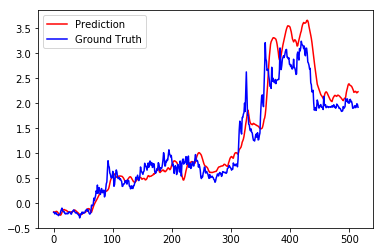

In [41]:
# if using within a jupyter notebook
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()

This code generates a line plot using the matplotlib library. It plots two datasets - "pred" and "y_test" - on the same plot.   The "pred" dataset is plotted in red and labeled as "Prediction" while the "y_test" dataset is plotted in blue and labeled as "Ground Truth".   Finally, the plot is displayed with a legend indicating the labels and their corresponding colors.